In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from haversine import haversine

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we skip the subsampling step here.

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 of our entries list basement size as '?'. Since we have columns that measures square footage above basement and square footage, reassign square footage of basement with sqft_living - sqft_above.

In [5]:
mask = house_data['sqft_basement'] == '?'
house_data.loc[mask, 'sqft_basement'] = (house_data['sqft_living'] - house_data['sqft_above'])
house_data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,0,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [6]:
house_data['view'].isna().sum()

63

We have 63 NaN values for view. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Since so many values here are 0 and we don't want to make any unsafe assumptions, we elect to drop this column entirely.

In [9]:
house_data = house_data.drop('yr_renovated', axis=1)

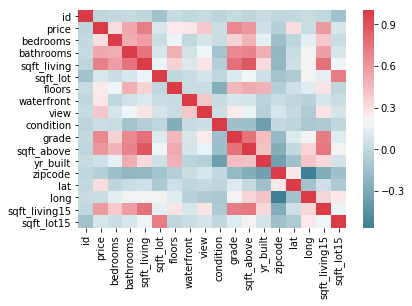

In [10]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [11]:
house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.017392,0.000991,0.004971,-0.012381,-0.132061,0.018573,-0.004872,0.011592,-0.023944,0.008331,-0.010967,0.021609,-0.008027,-0.002001,0.020637,-0.002707,-0.138607
price,-0.017392,1.000000,0.308063,0.525053,0.701587,0.090338,0.257052,0.270982,0.395734,0.035393,0.668307,0.605695,0.054273,-0.053620,0.307868,0.022417,0.585304,0.083189
bedrooms,0.000991,0.308063,1.000000,0.514368,0.577934,0.032735,0.177391,-0.004082,0.078523,0.026402,0.356095,0.479148,0.155462,-0.153990,-0.010415,0.132318,0.392874,0.030952
bathrooms,0.004971,0.525053,0.514368,1.000000,0.755277,0.088921,0.502285,0.064608,0.186451,-0.126682,0.665312,0.686173,0.507565,-0.204435,0.024487,0.225025,0.569139,0.088854
sqft_living,-0.012381,0.701587,0.577934,0.755277,1.000000,0.173768,0.353529,0.107416,0.282532,-0.059783,0.762398,0.876553,0.318217,-0.199839,0.052383,0.241856,0.756208,0.184801
sqft_lot,-0.132061,0.090338,0.032735,0.088921,0.173768,1.000000,-0.005025,0.023164,0.075298,-0.008375,0.115122,0.184325,0.052646,-0.129846,-0.085143,0.230137,0.145142,0.717095
floors,0.018573,0.257052,0.177391,0.502285,0.353529,-0.005025,1.000000,0.021399,0.028436,-0.264138,0.458694,0.523367,0.489410,-0.058966,0.049419,0.125329,0.279176,-0.010850
waterfront,-0.004872,0.270982,-0.004082,0.064608,0.107416,0.023164,0.021399,1.000000,0.406654,0.017175,0.085644,0.073500,-0.026612,0.031656,-0.012911,-0.040097,0.087257,0.031958
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023944,0.035393,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.017175,0.045735,1.000000,-0.147326,-0.158830,-0.361398,0.002125,-0.015594,-0.105475,-0.093172,-0.002702


Due to high collinearity with other variables, we choose to drop zipcode, sqft_above, and sqft_living15. Furthermore, we dropped grade because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms, which suggests high collinearity (as reflected in the numbers).

In [12]:
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [13]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 16 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       19164 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.8+ MB


In [14]:
# Waterfront has null values, since the number of nulls is a little high, fill with the highest categorical which is 0
house_data = house_data.fillna(0)

We want to see if the target is normally distributed as this is an assumption made with linear regression.

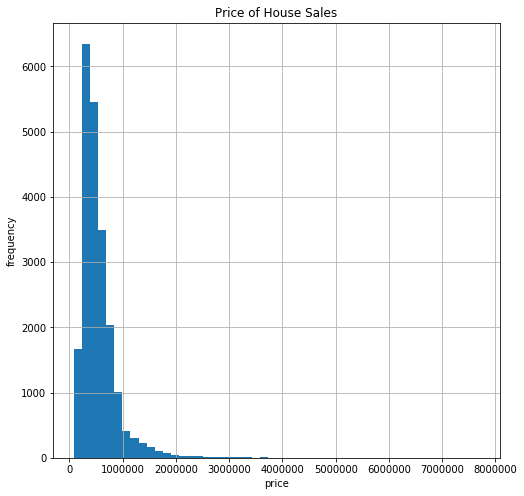

In [15]:
plt.figure(figsize=(8,8))
house_data['price'].hist(bins=50)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Price of House Sales')
plt.show()

Price is not normally distributed. A log transformation will be performed to rectify that.

In [16]:
house_data['log_price'] = house_data['price'].apply(lambda x: np.log(x))

In [17]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166


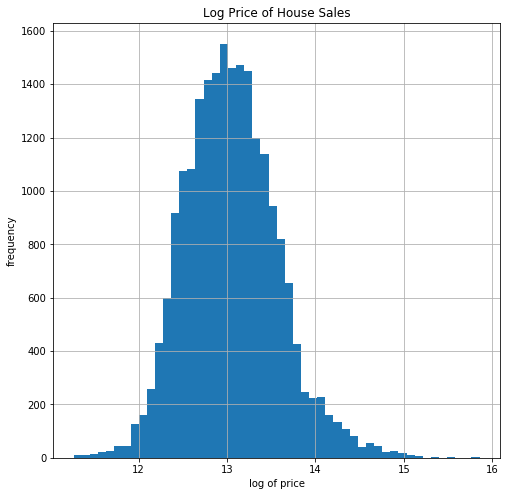

In [18]:
plt.figure(figsize=(8,8))
house_data['log_price'].hist(bins=50)
plt.xlabel('log of price')
plt.ylabel('frequency')
plt.title('Log Price of House Sales')
plt.show()

Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

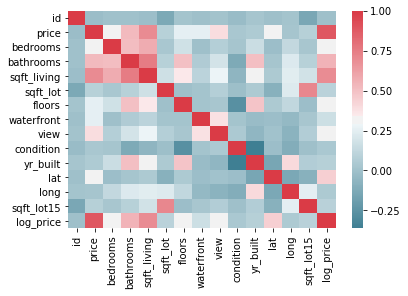

In [19]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

Most of our highly collinear variables are gone, great! But our remaining strongest predictors (e.g. bathrooms, bedrooms, and sqft_living) still have high collinearity with each other. In spite of this we decide to leave them, and resolve to test our model carefully to get the best accuracy we can without too much overfitting.

Our goal is to cater to as many potential house-buyers as possible. We therefore target the 90th percentile of home sale prices and disregard the rest to improve accuracy of the majority. We will show the accuracy once we get to building our models.

In [20]:
# we want to target our model to the majority of users, 
# but perhaps not to the people that are buying mansions/celebrities in the area
price_90th_perc = np.percentile(house_data['log_price'], 90)

house_data_90 = house_data.drop(house_data[house_data['log_price'] > price_90th_perc].index)

In [21]:
price_95th_perc = np.percentile(house_data['log_price'], 95)

house_data_95 = house_data.drop(house_data[house_data['log_price'] > price_95th_perc].index)

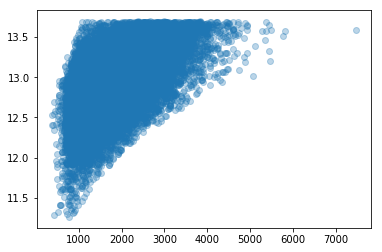

In [22]:
plt.scatter(house_data_90['sqft_living'], house_data_90['log_price'], alpha=0.3)

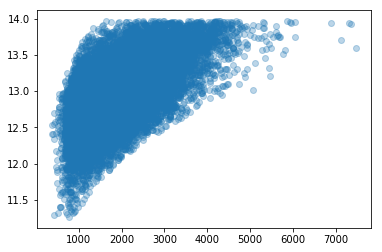

In [23]:
plt.scatter(house_data_95['sqft_living'], house_data_95['log_price'], alpha=0.3)

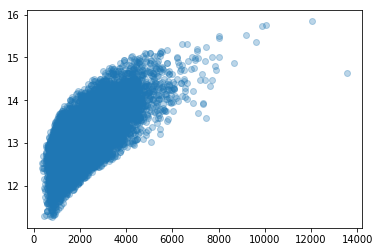

In [24]:
plt.scatter(house_data['sqft_living'], house_data['log_price'], alpha=0.3)

In [25]:
# remove strong outliers in sqft_living and bedrooms
house_data_90 = house_data_90.drop(house_data_90[house_data_90['sqft_living'] > 12000].index)
house_data_90 = house_data_90.drop(house_data_90[house_data_90['bedrooms']>30].index)

house_data_95 = house_data_95.drop(house_data_95[house_data_95['sqft_living'] > 12000].index)
house_data_95 = house_data_95.drop(house_data_95[house_data_95['bedrooms']>30].index)

house_data_100 = house_data.drop(house_data[house_data['sqft_living'] > 12000].index)
house_data_100 = house_data.drop(house_data[house_data['bedrooms']>30].index)

In [119]:
# get a simple linear regression model for price and sqft_living
x_90 = np.array(house_data_90['sqft_living']).reshape(-1,1)
y_90 = np.array(house_data_90['log_price'])

x_95 = np.array(house_data_95['sqft_living'])
y_95 = np.array(house_data_95['log_price'])

x_100 = np.array(house_data_100['sqft_living'])
y_100 = np.array(house_data_100['log_price'])

In [27]:
def simple_linear_model(predictor, target, df):
    """Provides model the simple linear regression model between a predictor and target"""
    x = predictor
    y = target
    formula = 'y~x'
    model = ols(formula=formula, data=df).fit()
    return model.summary()

In [28]:
print(simple_linear_model(x_90, y_90, house_data_90))
print(simple_linear_model(x_95, y_95, house_data_95))
print(simple_linear_model(x_100, y_100, house_data_100))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8793.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:15:45   Log-Likelihood:                -6842.5
No. Observations:               19380   AIC:                         1.369e+04
Df Residuals:                   19378   BIC:                         1.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3209      0.007   1755.023      0.0

In [29]:
def test_median_err(predictors, target):
    """Train a model on the variables provided and return that model's MAE."""
    X = np.array(predictors)
    y = np.array(target)
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [120]:
sqft_living_mae_90 = test_median_err(x_90, y_90.reshape(-1,1))
sqft_living_mae_95 = test_median_err(x_95.reshape(-1,1), y_95.reshape(-1,1))
sqft_living_mae_100 = test_median_err(x_100.reshape(-1,1), y_100.reshape(-1,1))

sqft_living_mae_90, sqft_living_mae_95, sqft_living_mae_100

(106772.05015950123, 111558.2092983593, 116543.04107638584)

After completing an initial model, it is easier to fit to the 90th percentile than to the 95th or 100th percentile of the data. 

In [31]:
# plt.figure(figsize=(8,8))
# plt.scatter(x_90,y_90, label='scatter', alpha = 0.3)
# plt.plot(x_90, y_hat_90, color='red', label='linear regression')
# plt.title('Square foot of living and their log(prices)')
# plt.legend()
# plt.xlabel('square footage of living space')
# plt.ylabel('log(price)')
# plt.show()

In [32]:
# Convert date strings to datetime. May work with this later.

In [33]:
from datetime import datetime

house_data_90['date'] = pd.to_datetime(house_data['date'])
house_data_90['date'].sort_values().head()

16302   2014-05-02
2485    2014-05-02
16909   2014-05-02
8883    2014-05-02
3320    2014-05-02
Name: date, dtype: datetime64[ns]

What follows are our experiments with a preliminary multivariate model.

In [34]:
outcome = 'log_price'
predictors = house_data_90.loc[:, ['sqft_living', 'yr_built', 'bedrooms', 'bathrooms', 'view']]
predictors_int = sm.add_constant(predictors)
model = sm.OLS(np.asarray(house_data_90['log_price']), np.asarray(predictors_int)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2202.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:15:47   Log-Likelihood:                -6107.4
No. Observations:               19380   AIC:                         1.223e+04
Df Residuals:                   19374   BIC:                         1.227e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3267      0.196     93.539      0.000      17.943      18.711
x1             0.0003   5.16e-06     61.225      0.000       0.000       0.000
x2            -0.0031      0.000    -30.419      0.000      -0.003      -0.003
x3            -0.0639      0.003    -18.272      0.000      -0.071      -0.057
x4             0.1367      0.006     24.582      0.000       0.126       0.148
x5             0.0535      0.004     12.894      0.000       0.045       0.062
==============================================================================
Omnibus:                      277.494   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.494
Skew:                          -0.285   Prob(JB):                     2.75e-62
Kurtosis:                       2.837   Cond. No.                     2.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
X_train, X_test, y_train, y_test = train_test_split(predictors, house_data_90['log_price'], test_size=0.3)

In [36]:
m_linreg = LinearRegression()

m_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
m_linreg.coef_

array([ 0.00031896, -0.00304491, -0.06659144,  0.13446737,  0.05614622])

In [38]:
m_linreg.intercept_

18.267431481978534

In [39]:
y_hat_train = np.exp(m_linreg.predict(X_train))
y_hat_test = np.exp(m_linreg.predict(X_test))

In [40]:
test_mae = median_absolute_error(y_test,y_hat_test)

print('test: ' + str(test_mae))

test: 403271.2476601392


In [41]:
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(m_linreg, predictors, house_data_90['log_price'], cv=5, scoring='neg_median_absolute_error')

cv_5_results = -1*cv_5_results
cv_5_results

array([0.24997408, 0.24925952, 0.25032886, 0.25303628, 0.23480804])

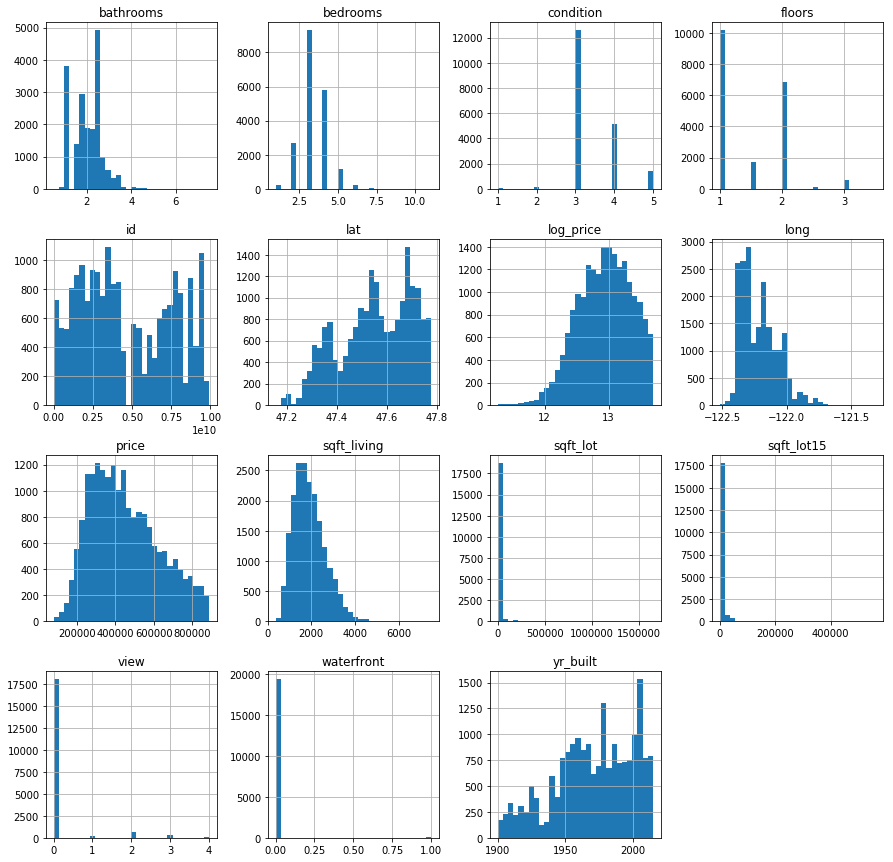

In [42]:
_ = house_data_90.hist(figsize=(15,15), bins=30)

Create a column for distance from downtown Seattle (latitude and longitude provide by Google Maps). We expect it to be a useful predictor as Seattle and it's neighboring cities have a large proportion of job opportunities and higher population density.

In [43]:
downtown_sea = (47.609795, -122.337173) #(lat, lon)

In [44]:
house_data_90['lat_long'] = list(zip(house_data_90['lat'], house_data_90['long']))
house_data_90.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)"
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)"
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)"
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)"
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)"


In [45]:
house_data_90['distance_from_downtown_sea'] = house_data_90['lat_long'].apply(lambda x: haversine(downtown_sea, x, unit='mi'))

In [46]:
house_data_90.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434


The dates in this dataframe range from 2014 to 2015. We may want to adjust the price to account for inflation in 2019. $1 in 2014 is the equivalent of $1.07 in 2019.

In [47]:
house_data_90['2019_price'] = house_data_90['price'].apply(lambda x: x*1.07)
house_data_90.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea,2019_price
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463,237433.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926,575660.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232,192600.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113,646280.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434,545700.0


In [48]:
predictors = house_data_90.columns
predictors = list(predictors)
predictors.remove('date')
predictors.remove('price')
predictors.remove('log_price')
predictors.remove('lat_long')
predictors.remove('2019_price')
predictors

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_lot15',
 'distance_from_downtown_sea']

In [49]:
predictor_mae = {}
for predictor in predictors:
    x = house_data_90[[predictor]]
    y = house_data_90['log_price']
    predictor_mae[predictor] = test_median_err(x,y)

sorted_predictor_mae = sorted(predictor_mae.items(), key=lambda x :x[1])
sorted_predictor_mae

[('lat', 101382.96181174372),
 ('sqft_living', 106949.86816967504),
 ('distance_from_downtown_sea', 112998.1356978849),
 ('bathrooms', 115183.41997230655),
 ('sqft_basement', 121439.25804679205),
 ('floors', 123729.32839306709),
 ('bedrooms', 123853.10339690508),
 ('view', 123928.28667930595),
 ('sqft_lot15', 125511.40920464073),
 ('long', 126157.38864895041),
 ('id', 126241.29871532081),
 ('sqft_lot', 126414.54278592586),
 ('waterfront', 126563.93535916638),
 ('condition', 127193.90149090113),
 ('yr_built', 127491.60284162927)]

In [50]:
def kfolds(data, k):
    """Convert data to a dataframe and construct k-tolds for train-test"""
    # create a dataframe from the data
    df = pd.DataFrame(data)
    
    #find the number of rows in the data frame
    num_observations = len(df)
    
    # determine how large the folds are as well as how much leftover
    rows_in_folds = num_observations//k #floor division
    leftover_rows = num_observations%k
    
    folds = [] #make a list of fold sizes
    starting_row = 0  # start the fold at this row
    for i in range(k):
        if leftover_rows > 0:
            folds.append(df.iloc[starting_row : starting_row+rows_in_folds+1])
            leftover_rows -= 1
            starting_row += rows_in_folds + 1
        else:
            folds.append(df.iloc[starting_row : starting_row+rows_in_folds])
            starting_row += rows_in_folds
         
    return folds

In [51]:
def mae_for_kfolds(X, y, data, k):   #X is a list of predictor names. y is a list of the target name
    """Constructs an array of MAE values for k folds of data"""
    folds = kfolds(data, k) #constructs kfolds
    
    test_errs = []
    train_errs = []
    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i,fold in enumerate(folds) if i != n])
        test = folds[n]
        # Fit a linear regression model
        linreg = LinearRegression()
        test_err = []
        linreg.fit(train[X], train[y])
        #Evaluate Train and Test Errors
        y_hat_test = linreg.predict(test[X])
        y_hat_train = linreg.predict(train[X])
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(test[y])
        invert_y_hat_train = np.exp(y_hat_train)
        invert_y_train = np.exp(train[y])
        test_errs.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        train_errs.append(median_absolute_error(invert_y_train, invert_y_hat_train))
    return train_errs, test_errs

In [111]:
X1 = ['lat','sqft_living', 'bathrooms']
y = ['log_price']
mae_for_kfolds(X1, y, house_data_90, 10)

([71776.01090965954,
  71771.97214043417,
  71419.06595270961,
  72438.26361790512,
  71835.27503287,
  71747.76449425123,
  71970.93599225502,
  71910.82461853616,
  71889.61826135444,
  72573.40682787413],
 [73102.38934823862,
  74832.904648553,
  76611.20157705201,
  67908.23147085655,
  72100.15816549904,
  73869.84717792703,
  71836.03606251936,
  73078.53634080308,
  72359.0212302646,
  63135.32681806732])

One method to select factors.

In [53]:
# X and y are dataframes with specific columns

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [112]:
result = stepwise_selection(house_data_90[X1], house_data_90['log_price'], verbose = True)
print('resulting features:')
print(result)

Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  lat                            with p-value 0.0
resulting features:
['bathrooms', 'sqft_living', 'lat']


Another potential way to select factors

In [115]:
from sklearn.feature_selection import RFE

linreg = LinearRegression()
selector1 = RFE(linreg, n_features_to_select = 3)
selector1 = selector.fit(house_data_90[X1], house_data_90['log_price'])

In [116]:
print(X1)
print(selector1.support_)
print(selector1.ranking_)

['lat', 'sqft_living', 'bathrooms']
[ True  True  True]
[1 1 1]


In [57]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[1.47198837e+00 2.92549744e-04 5.33930534e-02]
-57.7294708395994


In [117]:
cv_1 = mae_for_kfolds(X1, y, house_data_90, 20)
train_errors = cv_1[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_1[0], cv_1[1]))]
np.mean(error_diffs), np.mean(train_errors)

(239.94236134110832, 71935.3997225902)

In [59]:
selector2 = RFE(linreg, n_features_to_select = 3)
selector2 = selector2.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector2.support_)
print(selector2.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False False  True False False False  True False False False False  True
 False False False]
[13  6  1  9 11  5  1  3  4 10  8  1  2 12  7]


In [118]:
X2 = ['bathrooms','waterfront', 'lat']
cv_2 = mae_for_kfolds(X2, y, house_data_90, 10)

train_errors = cv_2[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_2[0], cv_2[1]))]
np.mean(error_diffs), np.mean(train_errors)

(311.40846471257976, 84753.3042393607)

In [63]:
selector3 = RFE(linreg, n_features_to_select = 3)
selector3 = selector4.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector4.support_)
print(selector4.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False False  True False False False  True False False False False  True
  True False False]
[12  5  1  8 10  4  1  2  3  9  7  1  1 11  6]


In [64]:
X12 = ['bathrooms','waterfront', 'lat', 'long']
X12_mae = mae_for_kfolds(X12, y, house_data_90, 10)

print(X12_mae)
np.mean(X12_mae)

([84107.21199066166, 83444.252754221, 83632.5207731635, 84755.10630415753, 84000.92691565823, 83857.94201771475, 83853.94817236604, 84156.77627331152, 83539.90363591167, 83868.50003887448], [81016.7714814369, 88499.23001193594, 85636.49752549373, 78209.93441909499, 82364.10815474488, 85236.97438392197, 84037.52561364167, 83106.96708250855, 85561.8521309543, 85629.11927631492])


83925.80344780441

In [65]:
cv_3 = mae_for_kfolds(X12, y, house_data_90, 20)
print(cv_3[0]) #train
print(cv_3[1]) #test

[84554.25541336642, 83465.9708342824, 83988.43086583097, 83542.41183339857, 83934.65991995239, 83747.686778214, 84406.20323858611, 84173.826520395, 83995.05780288985, 84064.32645554759, 83941.9751505818, 83919.0568649068, 83940.75103094673, 83990.64576467237, 84034.5472431602, 84172.57869165257, 83927.01092910336, 83711.60892838304, 83895.06902143726, 84108.5044786632]
[71752.20487303991, 93477.66882391766, 83811.30347889703, 91640.15452634118, 83898.30136074033, 90196.98499382392, 76831.50485599908, 79718.72245765507, 83329.87542823283, 81094.09102602967, 84599.8079830918, 86688.61688447802, 87080.53925262956, 81460.59594150854, 83046.40622334252, 82799.02797995432, 84335.87410333462, 86732.27388558054, 85351.91477688166, 84487.12878822896]


In [66]:
# 10 tests better than train

In [67]:
selector5 = RFE(linreg, n_features_to_select = 5)
selector5 = selector5.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector5.support_)
print(selector5.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False False  True False False False  True  True False False False  True
  True False False]
[11  4  1  7  9  3  1  1  2  8  6  1  1 10  5]


In [68]:
X13 = ['bathrooms','waterfront', 'view', 'lat', 'long']
X13_mae = mae_for_kfolds(X13, y, house_data_90, 10)

print(X13_mae)
np.mean(X13_mae)

([81939.96138735139, 80926.02495072136, 81228.07500763764, 82303.24516740048, 81483.69321757121, 81632.25891122853, 81739.95800952743, 81970.03246117628, 81098.60271040477, 81146.76160659478], [78221.90775570355, 86441.89775489832, 83780.98659288694, 75255.12264767117, 80548.79994455111, 81445.1375712429, 79438.96965646809, 80770.50892581593, 86616.41126908589, 83984.82973665325])


81598.65926422956

In [69]:
cv_4 = mae_for_kfolds(X13, y, house_data_90, 20)
print(cv_4[0]) #train
print(cv_4[1]) #test

[82292.69740894315, 80992.16146490804, 81660.21517199234, 80859.93064504024, 81414.1088297317, 81398.59592308075, 81933.34891377515, 81896.16827693325, 81344.11165264048, 81713.29076482292, 81522.1861084078, 81712.71690563229, 81464.29811127589, 81889.34364309636, 81713.47941778379, 81834.7026386506, 81351.53969224071, 81152.11046482189, 81107.34209109994, 81225.21869555011]
[69387.76887095429, 88946.50173097028, 82312.87102898367, 90549.2482042145, 82056.48960570298, 85693.54503948492, 74643.234686099, 76019.01175399637, 81832.39950205712, 78733.10507417307, 82235.84666490875, 80008.26653025177, 82449.306082697, 78251.10047694249, 79360.3698420247, 81589.5963507739, 85750.35149677977, 86674.72087839001, 83866.20281753055, 83546.20036264462]


In [70]:
# 7 tests better than trains

In [71]:
outcome = 'log_price'
preds = house_data_90.loc[:, ['bathrooms', 'waterfront', 'view', 'lat', 'long']]
preds_int = sm.add_constant(preds)
model = sm.OLS(np.asarray(house_data_90['log_price']), np.asarray(preds_int)).fit()

model.summary()

array([293652.16605703, 547439.67565515, 415746.08311514, ...,
       310355.99650405, 459675.26633545, 310214.99186264])

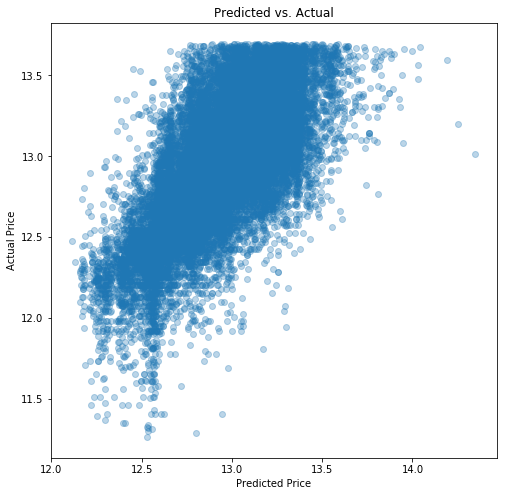

In [72]:
pred_val = model.predict()
fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs. Actual')
_ = ax.scatter(model.predict(), house_data_90['log_price'], alpha=0.3)

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
residuals = model.resid
scaler.fit(residuals.reshape(-1,1))
standard_resid = scaler.transform(residuals.reshape(-1,1))

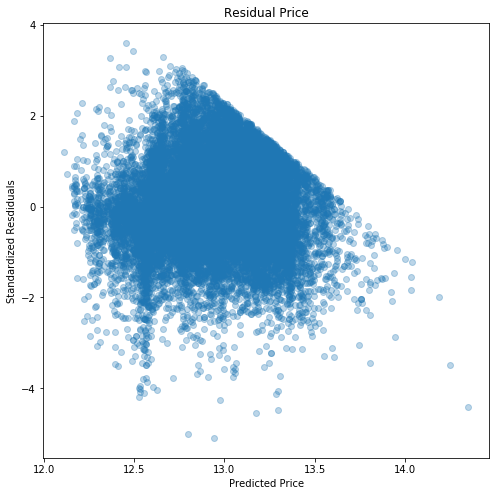

In [74]:
fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Standardized Resdiduals')
plt.title('Residual Price')
_ = ax.scatter(model.predict(), standard_resid, alpha=0.3)

In a residual plot we are hoping to have a rectangular cloud with no specific pattern around 0 of the Standardized Residuals. That is not necessarily what is happening here so we may want to further work on our model.

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


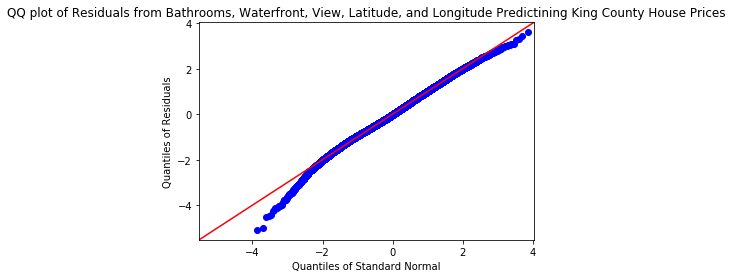

In [75]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.xlabel('Quantiles of Standard Normal')
plt.ylabel('Quantiles of Residuals')
plt.title('QQ plot of Residuals from Bathrooms, Waterfront, View, '+
          'Latitude, and Longitude Predictining King County House Prices')
fig.show()

In performing linear regression we hope that our residuals follow a normal distribution. Our data in blue mostly aligns with the normal with the exception of a lower tail that may indicate some heavy tailing.

In [76]:
selector6 = RFE(linreg, n_features_to_select = 6)
selector6 = selector6.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector6.support_)
print(selector6.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False False  True False False False  True  True  True False False  True
  True False False]
[10  3  1  6  8  2  1  1  1  7  5  1  1  9  4]


In [77]:
X14 = ['bathrooms','waterfront', 'view', 'condition', 'lat', 'long']
X14_mae = mae_for_kfolds(X14, y, house_data_90, 10)

print(X14_mae)
np.mean(X14_mae)

([81265.63390555562, 80081.44447356416, 80475.16271296823, 81515.26809470351, 80930.850462589, 80871.79147150842, 80844.57236660877, 80839.12435744744, 80147.47613912605, 80386.08826322852], [76570.17565166765, 86333.73846311783, 82216.6800012475, 75829.9423146341, 77518.0759187603, 80722.59139839039, 78591.12929442653, 82738.84637655728, 83953.11112786396, 83471.7330591926])


80765.1717926579

In [78]:
cv_5 = mae_for_kfolds(X14, y, house_data_90, 20)
print(cv_5[0]) #train
print(cv_5[1]) #test

[81444.35423931124, 80446.42229961086, 80726.06427691577, 80285.38727994857, 80699.75557861855, 80582.71380656812, 81046.39927947358, 81099.64597574633, 80618.92896475183, 80961.31784454983, 80669.04657292913, 80908.63383632276, 80722.81873204216, 81014.61186889198, 80882.60842942432, 80807.167883493, 80517.65616571764, 80438.91194808972, 80504.20035014738, 80574.9738711059]
[69434.46627263614, 87730.32655219239, 83754.01345805614, 89558.59557517845, 79090.98360591801, 86386.48405494704, 75604.93576293497, 75354.32061427395, 79852.23429478111, 75659.17822655133, 82124.72051080823, 79240.4107197157, 81770.76343035162, 75399.27375778506, 80643.38405660947, 82971.43832645146, 84086.48709942237, 84335.02179784502, 84205.74092206464, 83372.8684077455]


In [79]:
# 9 test errors better

In [80]:
preds14 = house_data_90.loc[:, ['bathrooms', 'waterfront', 'view', 'condition', 'lat', 'long']]
preds14_int = sm.add_constant(preds14)
model14 = sm.OLS(np.asarray(house_data_90['log_price']), np.asarray(preds14_int)).fit()

model14.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     3006.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:16:00   Log-Likelihood:                -4090.9
No. Observations:               19380   AIC:                             8196.
Df Residuals:                   19373   BIC:                             8251.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.2281      1.963    -18.452      0.000     -40.077     -32.380
x1             0.2606      0.003     80.023      0.000       0.254       0.267
x2             0.2110      0.049      4.281      0.000       0.114       0.308
x3             0.1166      0.004     30.419      0.000       0.109       0.124
x4             0.0652      0.003     19.356      0.000       0.059       0.072
x5             1.5240      0.015    100.316      0.000       1.494       1.554
x6             0.1970      0.016     12.493      0.000       0.166       0.228
==============================================================================
Omnibus:                       77.782   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.859
Skew:                          -0.090   Prob(JB):                     6.86e-21
Kurtosis:                       3.287   Cond. No.                     1.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

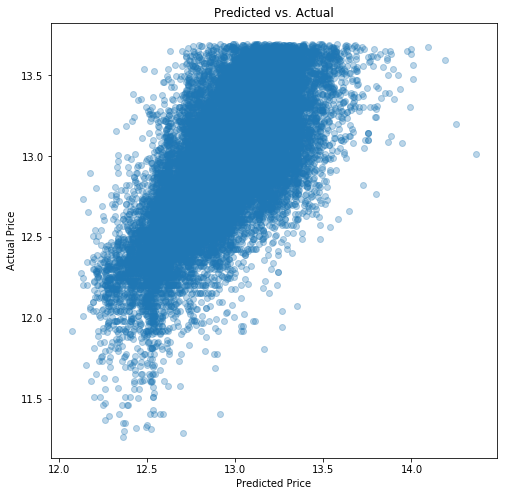

In [81]:
pred_val = model14.predict()
fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs. Actual')
_ = ax.scatter(model14.predict(), house_data_90['log_price'], alpha=0.3)

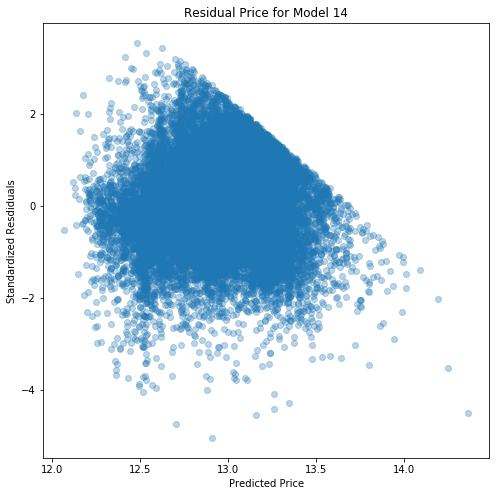

In [82]:
scaler14 = StandardScaler()
residuals14 = model14.resid
scaler14.fit(residuals14.reshape(-1,1))
standard_resid14 = scaler14.transform(residuals14.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Standardized Resdiduals')
plt.title('Residual Price for Model 14')
_ = ax.scatter(model14.predict(), standard_resid14, alpha=0.3)

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


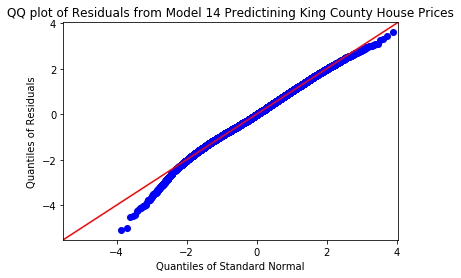

In [83]:
residuals14 = model.resid
fig = sm.graphics.qqplot(residuals14, dist=stats.norm, line='45', fit=True)
plt.xlabel('Quantiles of Standard Normal')
plt.ylabel('Quantiles of Residuals')
plt.title('QQ plot of Residuals from Model 14 Predictining King County House Prices')
fig.show()

In [84]:
selector7 = RFE(linreg, n_features_to_select = 7)
selector7 = selector7.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector7.support_)
print(selector7.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False False  True False False  True  True  True  True False False  True
  True False False]
[9 2 1 5 7 1 1 1 1 6 4 1 1 8 3]


In [85]:
X15 = ['bathrooms','floors','waterfront', 'view', 'condition', 'lat', 'long']
X15_mae = mae_for_kfolds(X15, y, house_data_90, 10)

print(X15_mae)
np.mean(X15_mae)

([80405.82278054388, 79470.65830607651, 79657.95051842817, 80575.44964185316, 80414.36307781196, 79901.80829735645, 80153.82036582506, 79973.9647155253, 79410.8104858131, 79829.86655120275], [76729.7978756962, 84302.75449013434, 81608.48432512101, 75689.09877000986, 76129.52579152596, 79002.21028121634, 77499.76013623585, 81452.46695457988, 83088.08802992615, 85485.51018530157])


80039.11057900917

In [86]:
cv_6 = mae_for_kfolds(X15, y, house_data_90, 20)
print(cv_6[0]) #train
print(cv_6[1]) #test

[80688.3794536945, 79678.24434612575, 79942.68870306812, 79577.86224704603, 79997.47331000434, 79579.3753145691, 80382.5383031278, 80289.0492774974, 79981.75709382817, 80269.84925692366, 79908.22976698814, 80078.38667290425, 79835.40828772349, 80276.16182840778, 80145.5002541538, 79896.78698167199, 79830.5456145039, 79630.23246591081, 79658.53800974757, 79813.28036789934]
[69364.57801883522, 86442.13946178381, 80539.701471759, 89309.10815151402, 78269.13788191468, 86647.45352331211, 75488.67751372332, 75571.72353184421, 76333.18995076814, 76041.90844973558, 81831.56473966746, 77781.05708395204, 80679.24390654833, 72762.93445171573, 79646.73787179956, 82891.48470416281, 82213.4209349624, 84663.20530119559, 85513.28118422563, 84116.23055026378]


In [87]:
# 9 tests better

In [88]:
preds15 = house_data_90.loc[:, ['bathrooms', 'floors', 'waterfront', 'view', 'condition', 'lat', 'long']]
preds15_int = sm.add_constant(preds15)
model15 = sm.OLS(np.asarray(house_data_90['log_price']), np.asarray(preds15_int)).fit()

model15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     2635.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:16:03   Log-Likelihood:                -3985.2
No. Observations:               19380   AIC:                             7986.
Df Residuals:                   19372   BIC:                             8049.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.8476      1.953    -18.356      0.000     -39.676     -32.020
x1             0.2349      0.004     63.714      0.000       0.228       0.242
x2             0.0694      0.005     14.582      0.000       0.060       0.079
x3             0.2007      0.049      4.094      0.000       0.105       0.297
x4             0.1196      0.004     31.328      0.000       0.112       0.127
x5             0.0775      0.003     22.421      0.000       0.071       0.084
x6             1.5151      0.015    100.193      0.000       1.485       1.545
x7             0.1974      0.016     12.587      0.000       0.167       0.228
==============================================================================
Omnibus:                       91.344   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.234
Skew:                          -0.103   Prob(JB):                     1.91e-24
Kurtosis:                       3.305   Cond. No.                     1.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

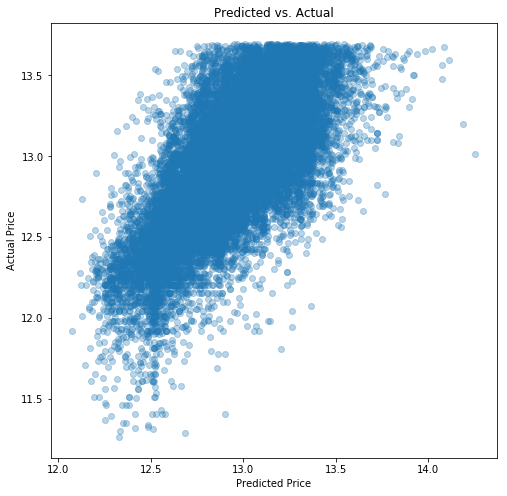

In [89]:
pred_val = model15.predict()
fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs. Actual')
_ = ax.scatter(model15.predict(), house_data_90['log_price'], alpha=0.3)

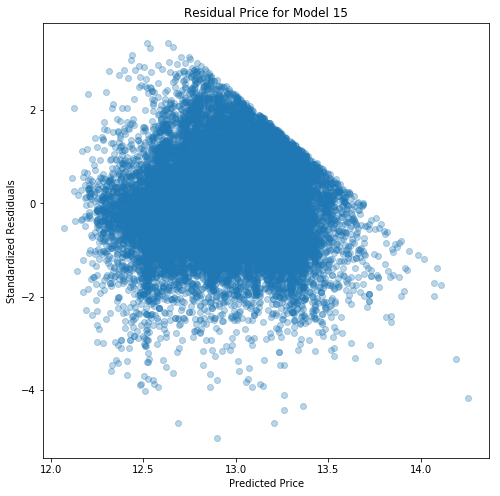

In [90]:
scaler15 = StandardScaler()
residuals15 = model15.resid
scaler15.fit(residuals15.reshape(-1,1))
standard_resid15 = scaler15.transform(residuals15.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Standardized Resdiduals')
plt.title('Residual Price for Model 15')
_ = ax.scatter(model15.predict(), standard_resid15, alpha=0.3)

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


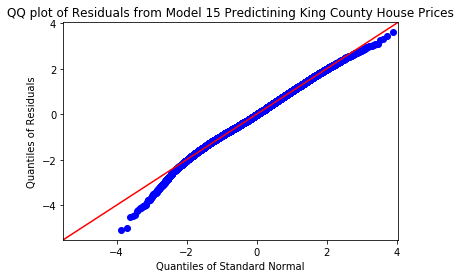

In [91]:
residuals15 = model.resid
fig = sm.graphics.qqplot(residuals15, dist=stats.norm, line='45', fit=True)
plt.xlabel('Quantiles of Standard Normal')
plt.ylabel('Quantiles of Residuals')
plt.title('QQ plot of Residuals from Model 15 Predictining King County House Prices')
fig.show()

In [92]:
selector8 = RFE(linreg, n_features_to_select = 8)
selector8 = selector8.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector8.support_)
print(selector8.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False  True  True False False  True  True  True  True False False  True
  True False False]
[8 1 1 4 6 1 1 1 1 5 3 1 1 7 2]


In [93]:
X16 = ['bedrooms','bathrooms','floors','waterfront', 'view', 'condition', 'lat', 'long']
X16_mae = mae_for_kfolds(X16, y, house_data_90, 10)

print(X16_mae)
np.mean(X16_mae)

([79522.96929168809, 78881.40698821595, 78718.07223983642, 80153.63052774366, 79369.75716863229, 79238.40831818666, 79487.80706581764, 79334.71543829128, 78696.02167205157, 79419.28153187563], [76440.11884171475, 83855.8457972958, 83541.25758885863, 74463.2198691958, 77070.28646188998, 80076.64656855327, 78206.83943511298, 80608.74897819434, 82342.08501226889, 80976.97558373073])


79520.20471895773

In [94]:
cv_7 = mae_for_kfolds(X16, y, house_data_90, 20)
print(cv_7[0]) #train
print(cv_7[1]) #test

[79986.6350060982, 78780.95555847918, 79419.41964181839, 78844.44357359334, 79041.26779891877, 78856.40396435736, 79609.48304225772, 79670.07968875254, 79324.86439388234, 79383.90647441224, 79101.24948252446, 79308.1890890298, 79065.53534315067, 79676.59215036337, 79428.8845579946, 79333.54527485213, 79015.09202796326, 78971.05352562887, 79375.23466953798, 79366.66043674696]
[67611.14940939768, 87992.48074155074, 80087.96690323157, 87541.30279687495, 79412.16606606456, 87032.48542870607, 75256.91283296538, 73128.65258421266, 77622.29136171425, 77893.07638321805, 82579.13118948179, 78141.70873529173, 81021.01037030393, 73865.89458368026, 78991.3456128178, 82532.03724908363, 81204.8297686131, 82794.57498913078, 78454.38332449208, 80866.7843524341]


In [95]:
train_errors = cv_7[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_7[0], cv_7[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-423.53444914514694, 79277.9747850181)

In [96]:
# 9 test

In [97]:
preds16 = house_data_90.loc[:, ['bedrooms','bathrooms', 'floors', 'waterfront', 'view', 'condition', 'lat', 'long']]
preds16_int = sm.add_constant(preds16)
model16 = sm.OLS(house_data_90['log_price'].values, preds16_int).fit()

model16.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     2387.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:16:06   Log-Likelihood:                -3820.1
No. Observations:               19380   AIC:                             7658.
Df Residuals:                   19371   BIC:                             7729.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.2281      1.938    -19.210      0.000     -41.027     -33.430
bedrooms       0.0514      0.003     18.244      0.000       0.046       0.057
bathrooms      0.1985      0.004     47.695      0.000       0.190       0.207
floors         0.0788      0.005     16.600      0.000       0.070       0.088
waterfront     0.2202      0.049      4.531      0.000       0.125       0.316
view           0.1206      0.004     31.853      0.000       0.113       0.128
condition      0.0725      0.003     21.103      0.000       0.066       0.079
lat            1.5234      0.015    101.552      0.000       1.494       1.553
long           0.1900      0.016     12.220      0.000       0.160       0.221
==============================================================================
Omnibus:                       78.229   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.288
Skew:                          -0.091   Prob(JB):                     5.53e-21
Kurtosis:                       3.287   Cond. No.                     1.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

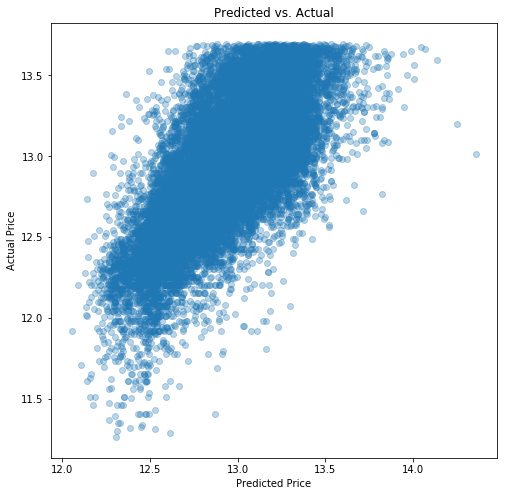

In [98]:
pred_val = model16.predict()
fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs. Actual')
_ = ax.scatter(model16.predict(), house_data_90['log_price'], alpha=0.3)

In [104]:
scaler16 = StandardScaler()
residuals16 = model16.resid
scaler16.fit(residuals16.reshape(-1,1))
standard_resid16 = scaler16.transform(residuals16.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Standardized Resdiduals')
plt.title('Residual Price for Model 16')
_ = ax.scatter(model16.predict(), standard_resid16, alpha=0.3)

AttributeError: 'Series' object has no attribute 'reshape'

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


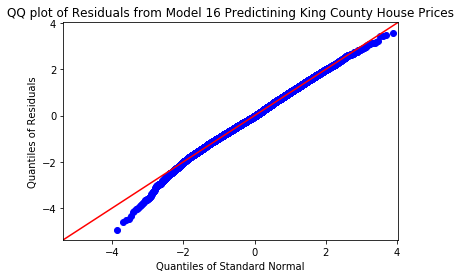

In [106]:
residuals16 = model16.resid
fig = sm.graphics.qqplot(residuals16, dist=stats.norm, line='45', fit=True)
plt.xlabel('Quantiles of Standard Normal')
plt.ylabel('Quantiles of Residuals')
plt.title('QQ plot of Residuals from Model 16 Predictining King County House Prices')
fig.show()

In [107]:
selector9 = RFE(linreg, n_features_to_select = 9)
selector9 = selector9.fit(house_data_90[predictors], house_data_90['log_price'])

print(predictors)
print(selector9.support_)
print(selector9.ranking_)

['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15', 'distance_from_downtown_sea']
[False  True  True False False  True  True  True  True False False  True
  True False  True]
[7 1 1 3 5 1 1 1 1 4 2 1 1 6 1]


In [108]:
X17 = ['bedrooms','bathrooms','floors','waterfront', 'view', 'condition', 'lat', 'long', 'distance_from_downtown_sea']
X17_mae = mae_for_kfolds(X17, y, house_data_90, 10)

print(X17_mae)
np.mean(X17_mae)

([75797.25864964355, 75532.957520836, 75371.1527098339, 75964.99494699849, 75456.49557929885, 76021.7457632995, 75608.721042655, 75757.59890751349, 75493.95546357249, 74600.9478599206], [72706.8036120816, 76445.8478140086, 78852.11430565172, 72421.84427629746, 74758.43086585672, 72981.85621785768, 75613.55950347119, 75743.43678216089, 75308.73469566178, 83437.80494365309])


75693.81307301365

In [109]:
cv_8 = mae_for_kfolds(X17, y, house_data_90, 20)
train_errors = cv_8[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_8[0], cv_8[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-272.6366294708365, 75555.42736642782)

In [ ]:
# 10 tests better 